# Transfer Learning

In [1]:
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms import v2
from torch.utils.data import DataLoader

This will download the ResNet18 model, which has been trained on the ImageNet image classification task.  Note when we print it out, there's a portion called `model.fc` (fc stands for fully-connected) which makes the transition from the feature extraction step to the classification step.  That's the part we're going to replace with a network of our own.

In [5]:
# download model
resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Here we build our Datasets from the train and test folders (`ImageFolder` is a Pytorch object that builds a dataset from images organized in a certain directory structure for classification purposes).  You will almost certainly want to add transformations to the `train_transforms` once you get it working.

In [6]:
# transforms for the training images
train_transforms = v2.Compose([
    v2.ToImage(),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=20),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(size=(256,256),antialias=True)
])

# transforms for the testing images (just reformatting)
test_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(size=(256,256),antialias=True)
])

# get images
training_data = torchvision.datasets.ImageFolder('train', transform=train_transforms)
testing_data = torchvision.datasets.ImageFolder('test', transform=test_transforms)

# create dataloaders
train_loader = DataLoader(training_data, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(testing_data, batch_size=64, shuffle=True, num_workers=4)

# save labels corresponding to index
labels = training_data.classes

We want Pytorch to know it doesn't need to keep track of gradients for the trained portion of the network.  The easiest way to do that, is to set all `parameters.requires_grad` to False, and then replace the `.fc` portion with a new network (which will be default have a `requires_grad` property of True).  Note our new `.fc` portion now has the correct number of output nodes for our classification task.

In [7]:
# freeze layers of downloaded model
for param in resnet.parameters():
    param.requires_grad = False

In [8]:
# create last layer of model to train (should take in the same number of features, but output the number of classes we have)
resnet.fc = nn.Linear(resnet.fc.in_features, len(training_data.classes))

# send the model to the GPU
resnet = resnet.to('cuda')

Train it!

In [9]:
# train model
def trainModel(model, epochs, lr):

    # cross entropy loss for error
    criterion = nn.CrossEntropyLoss()

    # use Adam for gradient/optimizer
    optimizer = optim.Adam(model.fc.parameters(), lr=.001)

    # do for each epoch
    for epoch in range(epochs):

        # keep track of best testing loss
        best_loss = -1

        # for each batch of training data
        for X, y in train_loader:

            # grab data matrix and correct labels, send to GPU
            X = X.to('cuda')
            y = torch.Tensor(y).to('cuda')

            # get predictions from model
            predictions = model(X)

            # calculate cross entropy loss
            loss = criterion(predictions, y)

            # calculate gradient
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # don't calculate gradients for testing loss
        with torch.no_grad():

            # loop through each batch of testing data
            for X, y in test_loader:

                # keep track of loss over multiple batches
                test_loss = 0

                # grab data matrix and correct labels, send to GPU
                X = X.to('cuda')
                y = torch.Tensor(y).to('cuda')

                # get predictions from model
                pred = model(X)

                # add up loss over each batch
                test_loss += criterion(pred, y).item()

            # calculate final test loss
            test_loss /= len(test_loader)

            # save model if a best testing loss has been achieved
            if test_loss < best_loss or best_loss == -1:
                torch.save(model, "bestModel")

    # return best model
    return torch.load("bestModel")

bestModel = trainModel(resnet, 100, 0.001)

KeyboardInterrupt: 

### The assignment

Your goal here is to evaluation transfer learning with ResNet18 on a number of different datasets.  To do this, you'll need a function that outputs an accuracy measure, and builds a confusion matrix.

Build several datasets, and evaluate success.  Here are some questions to explore:

- How does adding more classes impact the performance of your learned model? Are some classes harder to differentiate from each other than others (a confusion matrix would help)?
- How does adding more layers impact the speed of convergence and the ultimate performance of the model?
- Can you find some classes that you are unable to learn particularly well?
- If you add random transformations to the training set, how does test performance change? Does it take longer to overfit?

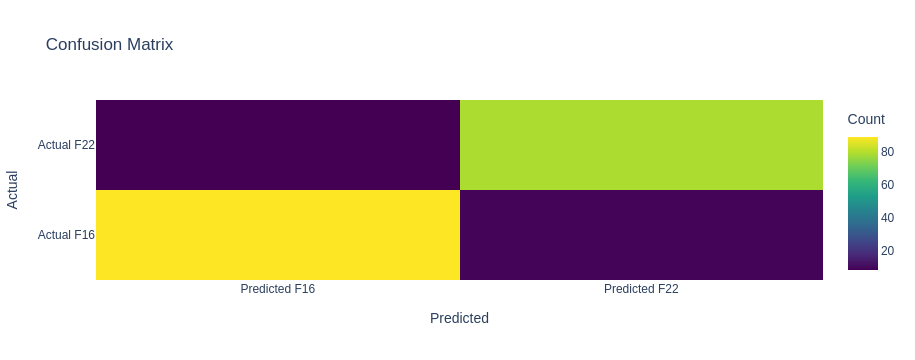

Testing Accuracy: 0.9081081081081082


In [66]:
# create confusion matrix and print testing accuracy for given model and test data
# this was created using guidance from ChatGPT in addition to notebook example
def modelResults(model, test):

    # set model to eval mode (not training the model)
    model.eval()

    # empty lists for actual and predicted labels
    preds = []
    actual = []

    # don't calculate gradient
    with torch.no_grad():

        # for each batch in testing data
        for X, y in test:

            # grab data matrix and correct labels, send to GPU
            X = X.to('cuda')
            y = torch.Tensor(y).to('cuda')

            # get predictions from model (one-hot encoding)
            pred = torch.max(model(X), 1)[1]

            # append labels to lists
            preds.extend(pred.cpu().numpy())
            actual.extend(y.cpu().numpy())

    # calculate confusion matrix
    confusion = confusion_matrix(actual, preds)

    # plot it
    fig = go.Figure(data = go.Heatmap(
        z = confusion,
        x = [f'Predicted {labels[i]}' for i in range(confusion.shape[0])],
        y = [f'Actual {labels[i]}' for i in range(confusion.shape[0])],
        colorscale = 'Viridis',
        colorbar = dict(title='Count'),
    ))
    fig.update_layout(
        title="Confusion Matrix",
        xaxis_title = "Predicted",
        yaxis_title = "Actual"
    )
    fig.show()

    # print testing accuracy
    print(f"Testing Accuracy: {np.mean(np.array(preds) == np.array(actual))}")

modelResults(bestModel, test_loader)

- Adding more classes didn't affect performance of the model too much. So long as the classes aren't overly similar to each other, the model should already be fairly good at distinguishing features from the transferred parameters. With just the F-22 and F-16, the model achieved a 90.8% accuracy. After adding three more aircraft, the accuracy changed to __________
- Adding more layers after the convolutional network could result in better results, but with the limited training/testing datasets, you would need to be much more careful about overfitting. I didn't think another layer was necessary with such high accuracies, since the last layer was mostly just using the transferred learning and re-categorizing the results.
- I thought that just the example classes, F-22s and F-16s would be hard enough to distinguish. They both literally (mostly) gray fighter jets, so I figured the model would have some trouble distinguishing them. However, the model did remarkably well, so I added three new classes of aircraft (MV-22, F-35, and EA-18G).
- Adding random transformations certainly helped the model, especially because our datasets are so small. Additionally, it probably took longer to overfit because the training data changes for each epoch.